# GARLIC

General-purpose Adaptive Richardson-Lucy Image Characterisation

# 1. Initialisation

## Import libraries and scripts

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import AutoMinorLocator

import ipywidgets as widgets
from IPython.display import display

import numpy as np
from time import time
from scipy import ndimage

import importlib
import scripts
importlib.reload(scripts)

> DEBUG: all scripts have been reloaded
> DEBUG: all scripts have been reloaded


<module 'scripts' from '/home/yago/public/git/paranoya/image-processing/scripts/__init__.py'>

Plotting:

In [2]:
def new_figure(fig_name, figsize=(10, 5), nrows=1, ncols=1, sharex='col', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0}):
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=figsize)
    axes = fig.subplots(nrows=nrows, ncols=ncols, squeeze=False,
                        sharex=sharex, sharey=sharey,
                        gridspec_kw=gridspec_kw
                       )
    fig.set_tight_layout(True)
    for ax in axes.flat:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
        ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
        ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
        ax.grid(True, which='both')

    fig.suptitle(fig_name)
    
    return fig, axes

In [3]:
default_cmap = plt.get_cmap("gist_earth").copy()
default_cmap.set_bad('gray')


def colour_map(ax, cblabel, data, cmap=default_cmap, norm=None, xlabel=None, x=None, ylabel=None, y=None):
    
    if norm is None:
        percentiles = np.array([1, 16, 50, 84, 99])
        ticks = np.nanpercentile(data, percentiles)
        linthresh = np.median(data[data > 0])
        norm = colors.SymLogNorm(vmin=ticks[0], vmax=ticks[-1], linthresh=linthresh)
    else:
        ticks = None
    if y is None:
        y = np.arange(data.shape[0])
    if x is None:
        x = np.arange(data.shape[1])

    im = ax.imshow(data,
                   extent=(x[0]-(x[1]-x[0])/2, x[-1]+(x[-1]-x[-2])/2, y[0]-(y[1]-y[0])/2, y[-1]+(y[-1]-y[-2])/2),
                   interpolation='nearest', origin='lower',
                   cmap=cmap,
                   norm=norm,
                  )
    #ax.set_aspect('auto')
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

    cb = fig.colorbar(im, ax=ax, orientation='vertical', shrink=.9)
    cb.ax.set_ylabel(cblabel)
    if ticks is not None:
        cb.ax.set_yticks(ticks=ticks, labels=[f'{value:.3g} ({percent}%)' for value, percent in zip(ticks, percentiles)])
    cb.ax.tick_params(labelsize='small')
    
    return im, cb


## Read data

In [4]:
importlib.reload(scripts.read_data)
object_name, data, wcs = scripts.read_data.run(11, (0, 0, 1))

Read dataset 11: "Sky spectrum" (7341,) (0.0125 s)


# 2. Multi-scale RL

## Parameters
(and reasonable defaults)

In [21]:
resolution_boost = 4
n_radii = 100

In [22]:
min_scale = resolution_boost / 2
max_scale = np.sqrt(data.size * resolution_boost)

Automatically set smoothing radii:

In [23]:
#initial_guess = np.linspace(min_scale, max_scale, n_radii)
initial_guess = np.logspace(np.log10(min_scale), np.log10(max_scale), n_radii)
smoothing_radii = initial_guess

## RL loop

In [24]:
#def GARLIC(data, smoothing_radii, resolution_boost=4):
#    """General-purpose Adaptive Richardson-Lucy Image Characterisation"""

# remove NaN and negative values
offset = np.nanmin(data)
boosted_data = np.where(np.isfinite(data), data-offset, 0)
# boost resolution
original_pixel = np.arange(data.size * resolution_boost) / resolution_boost
boosted_data = np.interp(original_pixel, np.arange(data.size), boosted_data)
boosted_data = ndimage.gaussian_filter(boosted_data, resolution_boost/2)

epsilon = 1e-3*np.min(data[data > 0])
RL = np.ones((smoothing_radii.size,) + boosted_data.shape)
rms_residual = np.inf
while rms_residual > np.std(RL):

    estimate = np.empty_like(RL)
    for i, radius in enumerate(smoothing_radii):
        estimate[i] = ndimage.gaussian_filter(RL[i], radius)
    estimate = np.sum(estimate, axis=0)
    rms_residual = np.std(boosted_data - estimate)

    for i, radius in enumerate(smoothing_radii):
         RL[i] *= ndimage.gaussian_filter((boosted_data+epsilon) / (estimate+epsilon), radius)
    print(rms_residual, np.std(RL))

    cumulative_flux_fraction = np.cumsum(np.sum(RL, axis=1))
    smoothing_radii = 10**np.interp(np.linspace(cumulative_flux_fraction[0], cumulative_flux_fraction[-1], n_radii), cumulative_flux_fraction, np.log10(smoothing_radii))
    #print(smoothing_radii)

#    return RL

1255.019328912757 9.247255196569377
652.289118147471 14.110908222046339
281.01256566097015 16.558564329875495
100.09043450763448 17.075556343188637
63.18890056043915 16.986975034029083
39.36170738489922 16.86674941205574
22.11192179346046 16.79989724265207
12.952355898257622 16.766774124333125


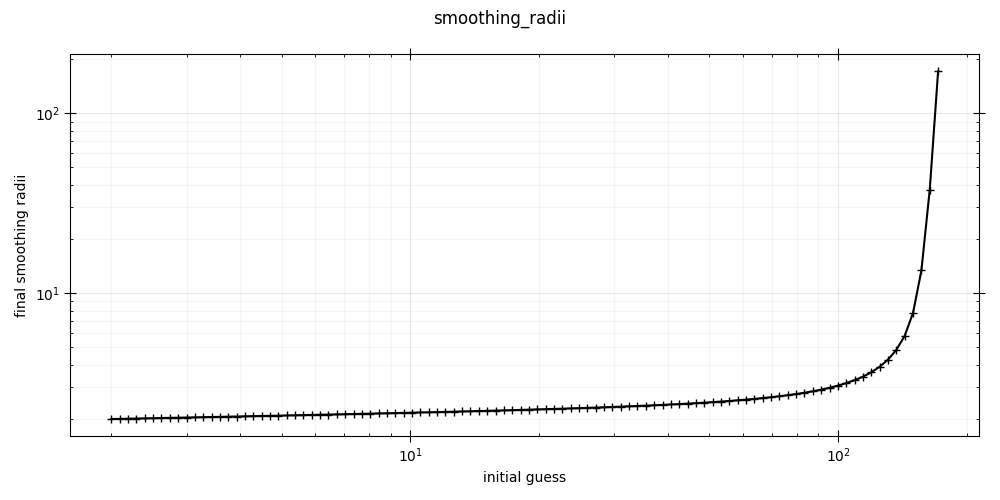

In [26]:
fig, axes = new_figure('smoothing_radii')

ax = axes[0, 0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('initial guess')
ax.set_ylabel('final smoothing radii')
ax.plot(initial_guess, smoothing_radii, 'k+-')

# 3. Source finding

## HOT
Hierarchical Overdensity Tree

In [27]:
importlib.reload(scripts.sort_data)
argsorted_data, n_valid = scripts.sort_data.run(RL.ravel())

Sorted 2936400 finite measurements in ascending order (0.301 s)


In [28]:
importlib.reload(scripts.HOT)
sorted_strides = np.hstack([np.sort(RL.strides)//RL.itemsize, RL.size]) # DIRTY HACK when testig particles at the boundary
t0 = time()
label, catalog = scripts.HOT.run(RL, argsorted_data, sorted_strides)
print(f'     {time()-t0:.3g} seconds')

HOT: 1348 overdensities found, 2936400 "pixels" (100%), 1 independent regions
     1.95 seconds


In [29]:
label.shape, RL.shape

((100, 29364), (100, 29364))

Plot results:

In [30]:
n_sources = np.unique(label).size
my_cmap = np.vstack([(np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, np.ones(n_sources)]).T
my_cmap[0, :] = [0., 0., 0., 1.]
final_cmap = colors.ListedColormap(my_cmap)

/tmp/ipykernel_27094/854010310.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{radius:.1f}' for radius in smoothing_radii[ticks]])
/tmp/ipykernel_27094/854010310.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{radius:.1f}' for radius in smoothing_radii[ticks]])


> 8.305608349531598 16.766774124333125


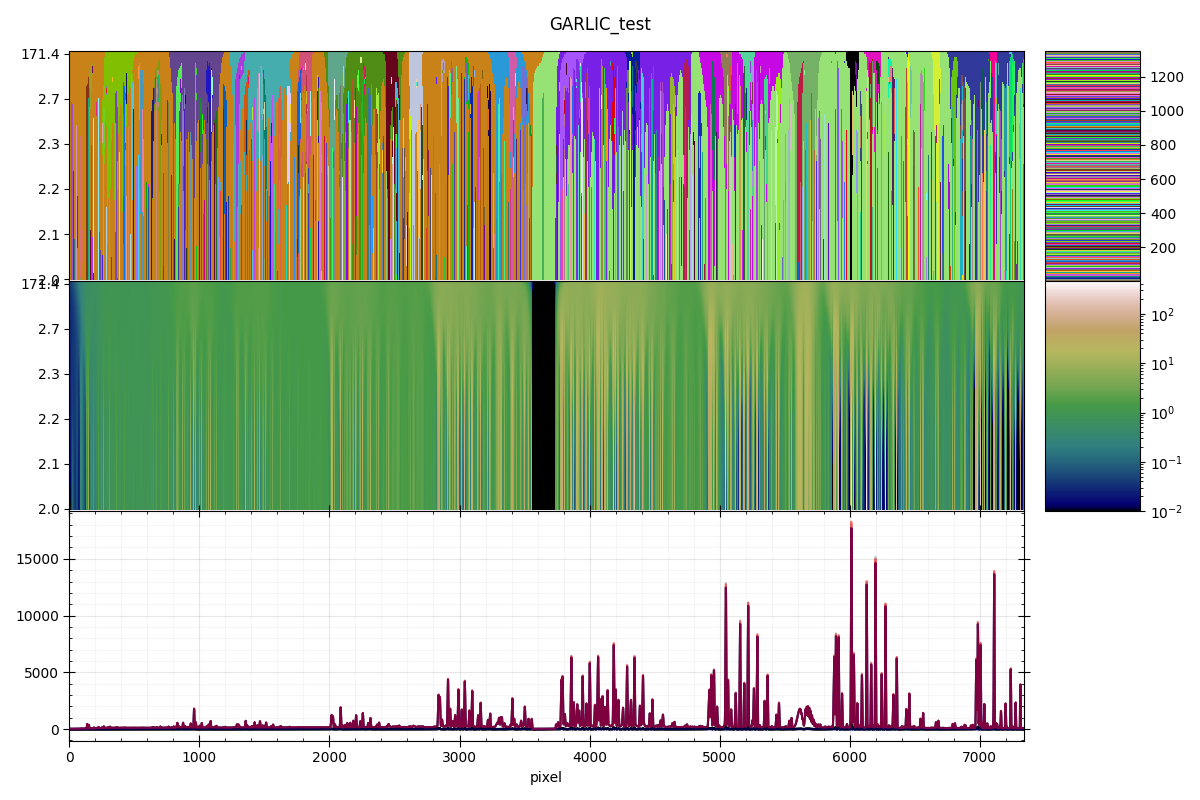

In [33]:
fig_name = 'GARLIC_test'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 8))
axes = fig.subplots(nrows=3, ncols=2, squeeze=False, sharex='col', gridspec_kw={'width_ratios': [1, .1], 'hspace': 0})
fig.suptitle(fig_name)
fig.set_tight_layout(True)


ax = axes[0, 0]
im = ax.imshow(label,
               extent = (original_pixel[0], original_pixel[-1], -.5, n_radii+.5),
               interpolation='nearest', origin='lower',
               cmap=final_cmap,
              )
ax.set_aspect('auto')
ax.set_ylim(-1, n_radii+1)
ticks = np.array(ax.get_yticks(), dtype=int).clip(0, n_radii-1)
ax.set_yticklabels([f'{radius:.1f}' for radius in smoothing_radii[ticks]])
cb = plt.colorbar(im, cax=axes[0, 1], orientation='vertical', shrink=.9)


ax = axes[1, 0]
im = ax.imshow(RL,
               extent = (original_pixel[0], original_pixel[-1], -.5, n_radii+.5),
               interpolation='nearest', origin='lower',
               cmap='gist_earth', norm=colors.LogNorm(vmin=1/n_radii),
              )
ax.set_aspect('auto')
ax.set_ylim(-1, n_radii+1)
ticks = np.array(ax.get_yticks(), dtype=int).clip(0, n_radii-1)
ax.set_yticklabels([f'{radius:.1f}' for radius in smoothing_radii[ticks]])
cb = plt.colorbar(im, cax=axes[1, 1], orientation='vertical', shrink=.9)


ax = axes[2, 0]
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
ax.grid(True, which='both')

ax.plot(data, 'k-', alpha=.2)
ax.plot(original_pixel, boosted_data + offset, 'k-')

estimate = np.empty_like(RL)
for i, radius in enumerate(smoothing_radii):
    ax.plot(original_pixel, RL[i], 'k-', alpha=.1)
    estimate[i] = ndimage.gaussian_filter(RL[i], radius)
estimate = np.sum(estimate, axis=0)
rms_residual = np.std(boosted_data - estimate)
print('>', rms_residual, np.std(RL))
ax.plot(original_pixel, estimate + offset, 'b-', alpha=.5)
ax.plot(original_pixel, boosted_data - estimate, 'b-', alpha=.25)
ax.plot(original_pixel, np.sum(RL, axis=0) + offset, 'r-', alpha=.5)

ax.set_xlabel('pixel')

axes[2, 1].axis('off')
plt.show()

# -- OLD STUFF --

# 2. Noise reduction

## Sorting

In [ ]:
argsorted_data.size, np.count_nonzero(mean_significance > 0)

# 3. Source finding

## Hierarchical Overdensity Tree (HOT)

In [ ]:
importlib.reload(scripts.HOT)
sorted_strides = np.hstack([np.sort(data.strides)//data.itemsize, data.size]) # DIRTY HACK when testig particles at the boundary
t0 = time()
label, catalog = scripts.HOT.run(data, argsorted_data, sorted_strides)
print(f'     {time()-t0:.3g} seconds')

In [ ]:
parent = catalog[0]
area = catalog[1]
test_stat = catalog[2]
#max_test_stat = catalog[3]

In [ ]:
#cut = 1 + np.mean(mean_significance)
#cut = 30
cut = np.nansum(data)/data.size

In [ ]:
fig_name = 'test_test_stat'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(8, 4))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex=True, sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0})

ax = axes[0, 0]  # ----------------- new panel
'''
ax.scatter(area, test_stat, s=1, alpha=.1)
#ax.set_yscale('symlog')
ax.set_ylim(-100, 200)
#ax.set_xlim(-.1, 20)
ax.set_xscale('log')

n_sources = np.count_nonzero((test_stat > cut) & (area > cut))
ax.axhline(cut, c='k', ls='--', label=f'{np.count_nonzero(test_stat > cut)}')
ax.axvline(cut, c='k', ls=':', label=f'{n_sources}')
'''

ax.scatter(mean_significance.flat, data.flat, s=1, alpha=.05)
ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(loc='upper right')

In [ ]:
def show_parents(labels, parents, ax):
    for obj in np.unique(labels):
        if area[obj] > 10:
            y_obj, x_obj = np.unravel_index(np.nanargmax(np.where(label == obj, data, -np.inf)), data.shape)
            y_par, x_par = np.unravel_index(np.nanargmax(np.where(label == parents[obj], data, -np.inf)), data.shape)
            #print(f'{obj}, {parents[obj]}, {x_obj, y_obj}')
            ax.plot([x_obj, x_par], [y_obj, y_par], 'k+-', alpha=.5)

def show_segmentation(intensity, labels):
    fig_name = 'segmentation'
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=(12, 8))
    
    axes = fig.subplots(nrows=2, ncols=2, squeeze=False,
                        sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})

    ax = axes[0, 0]
    ax.set_title(object_name)
    im = ax.imshow(
        intensity,
        interpolation='nearest', origin='lower',
        #cmap='ocean',
        #cmap='nipy_spectral',
        #cmap='terrain',
        #cmap='magma',
        #cmap='gist_heat',
        cmap='gist_earth',
        #cmap='YlGn',
        norm=colors.SymLogNorm(linthresh=np.nanmedian(intensity)),
        )
    cb = fig.colorbar(im, ax=ax, shrink=.7)

    ax = axes[0, 1]
    ax.set_title('Significance')
    im = ax.imshow(
        mean_significance,
        interpolation='nearest', origin='lower',
        cmap='gist_earth',
        #vmax=1,
        norm=colors.SymLogNorm(linthresh=np.nanmedian(mean_significance)),
        )
    cb = fig.colorbar(im, ax=ax, shrink=.7)

    ax = axes[1, 0]
    ax.set_title(f'segmentation')
    im = ax.imshow(
        #labels == study_object,
        labels,
        interpolation='nearest', origin='lower',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    cb = fig.colorbar(im, ax=ax, shrink=.7)
    #show_parents(labels, parent, ax)

    ax = axes[1, 1]
    ax.set_title(f'Test statistic')
    im = ax.imshow(
        test_stat[labels], #*area[labels],
        #np.where(labels == 8448, intensity, 0),
        interpolation='nearest', origin='lower',
        #cmap='nipy_spectral_r',
        #cmap='inferno_r',
        cmap='hot', vmin=cut/2, vmax=cut,
        #cmap='seismic_r', norm=colors.LogNorm(vmin=.1*cut, vmax=10*cut),
        )
    cb = fig.colorbar(im, ax=ax)

    for ax in axes.flatten():
        ax.tick_params(which='both', direction='in')
        ax.grid(alpha=.5)
    fig.set_tight_layout(True)
    plt.show()

In [ ]:
data_dimensionality = sorted_strides.size-1
n_sources = np.unique(label).size
my_cmap = np.vstack([(np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, np.ones(n_sources)]).T
my_cmap[0, :] = [0., 0., 0., 1.]
final_cmap = colors.ListedColormap(my_cmap)

if data_dimensionality == 2:
    show_segmentation(data, label)

elif data_dimensionality == 3:
    axis = 0
    intensity = np.nanmean(mean_significance, axis=axis)
    #intensity = np.nanmean(data**2, axis=1)
    #intensity = np.nanmax(data, axis=1)
    #intensity = np.cbrt(np.nanmean((mean_significance-np.nanmean(mean_significance))**3, axis=axis))
    pmin, p50, pmax = np.nanpercentile(intensity, [16, 50, 99])
    intensity_scale = colors.SymLogNorm(vmin=pmin, linthresh=2*p50-pmin, vmax=pmax)
    #intensity_scale = colors.Normalize(vmin=0, vmax=1)
    show_segmentation(intensity, np.nanmax(label, axis=axis), intensity_scale)


In [ ]:
np.count_nonzero(label == 7838), area[7838], test_stat[7838]

In [ ]:
x = data[label == 8448]
b = np.min(x)
np.sum(x), b, area[8448], x.size, np.sum(x)-b*x.size, test_stat[8448]

In [ ]:
fig_name = 'max_test_stat'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(8, 4))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex=True, sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0})

ax = axes[0, 0]  # ----------------- new panel

sources = np.where(reliability > 0)
sc = ax.scatter(test_stat[sources], max_test_stat[sources]/test_stat[sources],
                marker='o', s=10, c=reliability[sources], cmap='nipy_spectral_r')

ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
top = np.where(parent == np.arange(parent.size))[0]
top

In [ ]:
def print_children(node, level, max_level=6, max_children=2):
    children = np.where(parent == node)[0]
    print(f'{level*"|"}--{node} : A={area[node]}, T={test_stat[node]:.2g}({max_test_stat[node]:.2g}) R={reliability[node]:.2g}, {children.size} children')# ({children[:max_children]})')
    decreasing_area = np.argsort(area[children])[::-1]
    if level < max_level:
        for child in children[decreasing_area][:max_children]:
            if child != node: #and reliability[child] > 0:
                print_children(child, level+1, max_level, max_children)

print_children(top[1], 0)


## Reliability

In [ ]:
importlib.reload(scripts.reliability)
reliability = scripts.reliability.run(max_test_stat, area, plots=True)

In [ ]:
importlib.reload(scripts.reliability)
reliability = scripts.reliability.run(test_stat, area, plots=True)

In [ ]:
true_overdensity = reliability > 0.43
n_sources = np.count_nonzero(true_overdensity)
print(f'{n_sources} potential sources found')

## Clean-up

In [ ]:
fig_name = 'explore_significance'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(8, 8))

axes = fig.subplots(nrows=2, ncols=2, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0})
fig.suptitle(object_name)


def plot_projection(data, projection_axis, ax, transpose=False):
    intensity = np.cbrt(np.nanmean(data**3, axis=projection_axis))
    #intensity = np.nanmean(data, axis=projection_axis)
    if transpose:
        intensity = intensity.T
    print(intensity.shape)
    pmin, p50, pmax = np.nanpercentile(intensity, [1, 50, 99.9])
    intensity_scale = colors.SymLogNorm(vmin=pmin, linthresh=2*p50-pmin, vmax=pmax)
    im = ax.imshow(
        intensity,
        interpolation='nearest', origin='lower',
        cmap='rainbow',
        vmin=-pmax, vmax=pmax,
        #norm=intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax, shrink=.7)
    ax.set_aspect('auto')


plot_projection(mean_significance, 0, axes[1, 0])
plot_projection(mean_significance, 2, axes[1, 1], True)
plot_projection(mean_significance, 1, axes[0, 0])


for ax in axes.flatten():
    ax.tick_params(which='both', direction='in')
    ax.grid(alpha=.5)
fig.set_tight_layout(True)
plt.show()

In [ ]:
importlib.reload(scripts.cleanup)
label, old_label = scripts.cleanup.run(label, parent, area, true_overdensity, plots=True)

## Explore results

### Definitions

In [ ]:
plots = True
data_dimensionality = sorted_strides.size-1
#p0, p16, p50, p100 = np.nanpercentile(data, [0, 16, 50, 100])
#colour_scale = colors.SymLogNorm(vmin=p50-3*(p50-p16), linthresh= p50+3*(p50-p16), vmax=p100)
#data_min = data.ravel()[argsorted_data[0]]
#pivot = np.percentile(data[data > 0], 1)
#scale_min = data.ravel()[argsorted_data[int(argsorted_data.size*.01)]]
#pivot = data.ravel()[argsorted_data[int(argsorted_data.size*.5)]]  # median
#scale_max = data.ravel()[argsorted_data[int(argsorted_data.size*.99)]]
#scale_max = data.ravel()[argsorted_data[-1]]
#colour_scale = colors.SymLogNorm(vmin=scale_min, linthresh=2*pivot-scale_min, vmax=scale_max)
p0, p16, p50, p100 = np.nanpercentile(data, [0, 16, 50, 100])
colour_scale = colors.SymLogNorm(vmin=p16, linthresh=2*p50-p16, vmax=p100+p16)

#colour_scale = colors.LogNorm(vmin=p16, vmax=p100)

In [ ]:
n_sources = np.unique(label).size
my_cmap = np.vstack([(np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, np.ones(n_sources)]).T
my_cmap[0, :] = [0., 0., 0., 1.]
final_cmap = colors.ListedColormap(my_cmap)

### Segmentation

In [ ]:
def show_parents(labels, parents, ax):
    for obj in np.unique(labels):
        if area[obj] > 10:
            y_obj, x_obj = np.unravel_index(np.nanargmax(np.where(label == obj, data, -np.inf)), data.shape)
            y_par, x_par = np.unravel_index(np.nanargmax(np.where(label == parents[obj], data, -np.inf)), data.shape)
            #print(f'{obj}, {parents[obj]}, {x_obj, y_obj}')
            ax.plot([x_obj, x_par], [y_obj, y_par], 'k+-', alpha=.5)

def show_segmentation(intensity, labels, intensity_scale):
    fig_name = 'segmentation'
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=(12, 4))
    
    axes = fig.subplots(nrows=1, ncols=3, squeeze=False,
                        sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})

    ax = axes[0, 0]
    ax.set_title(object_name)
    im = ax.imshow(
        intensity,
        interpolation='nearest', origin='lower',
        #cmap='ocean',
        #cmap='nipy_spectral',
        #cmap='terrain',
        #cmap='magma',
        #cmap='gist_heat',
        cmap='gist_earth',
        #cmap='YlGn',
        norm=intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax, shrink=.7)

    ax = axes[0, 1]
    ax.set_title(f'segmentation ({n_sources} objects)')
    im = ax.imshow(
        #labels == study_object,
        labels,
        interpolation='nearest', origin='lower',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    cb = fig.colorbar(im, ax=ax, shrink=.7)
    #show_parents(labels, parent, ax)

    '''
    ax = axes[0, 1]
    ax.set_title(object_name)
    im = ax.imshow(
        total_weight,
        interpolation='nearest', origin='lower',
        #cmap='ocean',
        #cmap='nipy_spectral',
        cmap='terrain',
        norm = intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax)
    '''

    '''
    ax = axes[0, 2]
    ax.set_title(f'segmentation ({n_sources} objects)')
    im = ax.imshow(
        new_label,
        interpolation='nearest', origin='lower',
        cmap=final_cmap,
        )
    cb = fig.colorbar(im, ax=ax)
    '''

    '''
    ax = axes[0, 2]
    ax.set_title(f'Reliability')
    im = ax.imshow(
        reliability[old_label[labels]],
        interpolation='nearest', origin='lower',
        #cmap='nipy_spectral_r',
        #cmap='inferno_r',
        cmap='hot_r',
        #cmap='gist_heat',
        )
    cb = fig.colorbar(im, ax=ax)
    '''

    ax = axes[0, 2]
    ax.set_title(f'Test statistic')
    im = ax.imshow(
        test_stat[labels]*area[labels],
        interpolation='nearest', origin='lower',
        #cmap='nipy_spectral_r',
        #cmap='inferno_r',
        cmap='hot_r',
        norm=colors.LogNorm(vmin=1e-7, vmax=1e-3),
        )
    cb = fig.colorbar(im, ax=ax)

    for ax in axes.flatten():
        ax.tick_params(which='both', direction='in')
        ax.grid(alpha=.5)
    fig.set_tight_layout(True)
    plt.show()

In [ ]:
if plots and data_dimensionality == 2:
    show_segmentation(data, label, colour_scale)

elif plots and data_dimensionality == 3:
    axis = 0
    intensity = np.nanmean(mean_significance, axis=axis)
    #intensity = np.nanmean(data**2, axis=1)
    #intensity = np.nanmax(data, axis=1)
    #intensity = np.cbrt(np.nanmean((mean_significance-np.nanmean(mean_significance))**3, axis=axis))
    pmin, p50, pmax = np.nanpercentile(intensity, [16, 50, 99])
    intensity_scale = colors.SymLogNorm(vmin=pmin, linthresh=2*p50-pmin, vmax=pmax)
    #intensity_scale = colors.Normalize(vmin=0, vmax=1)
    show_segmentation(intensity, np.nanmax(label, axis=axis), intensity_scale)


In [ ]:
'''
'''
if plots and data_dimensionality == 3:

    mode = 0
    projection_axis = 0
    max_map = np.nanmax(label, axis=projection_axis)

    #boundary = np.zeros_like(max_map)
    #boundary[:, :-1][max_map[:, :-1] != max_map[:, 1:]] = 1
    #boundary[:-1, :][max_map[:-1, :] != max_map[1:, :]] = 1
    plt.close('filtered')
    fig = plt.figure('filtered', figsize=(8, 8))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'bottom': .01, 'left': .1, 'top': .99, 'right': .92,
                                   'hspace': .01, 'wspace': .1},
                      subplot_kw={'projection': wcs},
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    #fig.set_tight_layout(True)

    '''
    ax[0, 0].set_title('Input data (max)')
    im = ax[0, 0].imshow(
        np.nanmax(data, axis=0),
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colour_scale
    )
    '''
    ax[0, 0].set_title('Mean significance')
    im = ax[0, 0].imshow(
        np.nanmean(mean_significance, axis=projection_axis),
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colour_scale
        #norm = intensity_scale
    )
    #ax[0, 0].contour(boundary, levels=[.5], colors='k', linewidths=0.1)
    #ax[1, 0].contour(boundary, levels=[.5], colors='k', linewidths=0.1)
    #ax[1, 1].contour(boundary, levels=[.5], colors='k', linewidths=0.1)
    #ax[0, 0].contour(max_map, levels=np.arange(n_sources)+.5, colors='k', linewidths=0.1)
    #ax[1, 0].contour(max_map, levels=np.arange(n_sources)+.5, colors='k', linewidths=0.1)
    #ax[1, 1].contour(max_map, levels=np.arange(n_sources)+.5, colors='w', linewidths=0.1)
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(0, c='k', ls=':')
    #cb.ax.axhline(data.threshold-mode, c='k', ls='--')
    
    ax[0, 1].set_title('Input data (rms)')
    im = ax[0, 1].imshow(
        #(np.sqrt(np.nanmean((data-mode)**2, axis=0)) + np.nanmax(data, axis=0))/2,
        np.nansum(data, axis=projection_axis)/np.sqrt(np.nanmean(data**2, axis=projection_axis)),
        vmin=0,
        interpolation='nearest', origin='lower', cmap='terrain',
        #norm = colors.SymLogNorm(vmin=-delta_th, linthresh=3*delta_th, vmax=np.max(data-mode)),
        #vmin=-delta/100, vmax=3*delta/10,
        #norm = colour_scale,
    )
    #ax[0, 1].contour(max_map, levels=[0.5])
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(0, c='k', ls=':')
    #cb.ax.axhline(data.threshold-mode, c='k', ls='--')
    
    ax[1, 0].set_title(f'Final selection map (max)\n({n_sources} objects)')
    im = ax[1, 0].imshow(
        max_map,
        interpolation='nearest', origin='lower',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    #ax[1, 1].set_title('<lbl^2> / <lbl>')
    im = ax[1, 1].imshow(
        reliability[old_label[max_map]],
        #np.nansum(final_labels**2, axis=0) / np.nansum(final_labels, axis=0),
        interpolation='nearest', origin='lower',
        cmap='nipy_spectral_r',
        #vmin=n_reliable/(n_sources+1), vmax=reliability_threshold,
        #cmap='rainbow_r',
        #vmin=1, vmax=n_final_labels-1,
        )
    cb = fig.colorbar(im, ax=ax[1, 1])


In [ ]:
if plots and data_dimensionality == 3:
    x_range = np.round(plt.figure('segmentation').get_axes()[0].get_xlim()).astype(int)
    y_range = np.round(plt.figure('segmentation').get_axes()[0].get_ylim()).astype(int)
    section = (data[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]-mode)
    section_lables = label[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    norm = (y_range[1] - y_range[0]) * (x_range[1] - x_range[0])
    section_labels = label[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    unique_section_labels = np.unique(section_labels)

    vertical_slit = np.max(section_labels, axis=2).T
    horizontal_slit = np.max(section_labels, axis=1).T

    plt.close('spectrum')
    fig = plt.figure('spectrum', figsize=(8, 8))
    ax = fig.subplots(nrows=5, ncols=1, squeeze=False,
                      sharex=True, sharey=False,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        
    fig.set_tight_layout(True)

    
    ax[0, 0].set_title(f'Mean spectra for x in {x_range}, y in {y_range}\n({unique_section_labels.size} objects)')
    im = ax[0, 0].imshow(
        vertical_slit,
        interpolation='nearest', origin='lower',
        #vmin=0, vmax=n_final_labels-1, cmap='rainbow',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    ax[0, 0].set_aspect('auto')
    ax[0, 0].set_ylabel(r'$\Delta y$')


    im = ax[1, 0].imshow(np.nanmean(section, axis=2).T,
                         interpolation='nearest', origin='lower', cmap='terrain',
                         #norm=colour_scale,
                        )
    #ax[1, 0].contour(vertical_slit, levels=0)
    ax[1, 0].set_aspect('auto')
    ax[1, 0].set_ylabel(r'$\Delta y$')


    ax[2, 0].plot(np.nanmean(section, axis=(1, 2)), 'k-', lw=3, alpha=.25)
    ax[2, 0].set_ylabel('spectrum')
    '''
    '''
    for lbl in unique_section_labels[:10]:  # Dirty fix
        mask = np.zeros_like(section)
        mask[section_labels == lbl] = 1
        if lbl == 0:
            ls = ':'
        else:
            ls = '-'
        ax[2, 0].plot(np.nansum(section*mask, axis=(1, 2))/norm, alpha=.5, ls=ls, label=f'{lbl}')
    mean_error = 1/np.sqrt(section.shape[1]*section.shape[2])
    #ax[2, 0].axhline(delta_th*mean_error*bg_std, c='k', ls=':')
    #ax[2, 0].axhline(-delta_th*mean_error*bg_std, c='k', ls=':')
    ax[2, 0].legend()
    
    
    im = ax[3, 0].imshow(np.nanmean(section, axis=1).T,
        #(np.nanmax(section, axis=1) + np.sqrt(np.nanmean(section**2, axis=1))).T/2,
                         interpolation='nearest', origin='lower', cmap='terrain',
                         #vmin=0,
                         norm=colour_scale,
                        )
    #ax[3, 0].contour(horizontal_slit, levels=0)
    ax[3, 0].set_aspect('auto')
    ax[3, 0].set_ylabel(r'$\Delta x$')

    ax[4, 0].set_ylabel(r'$\Delta x$')
    im = ax[4, 0].imshow(
        horizontal_slit,
        interpolation='nearest', origin='lower',
        #vmin=0, vmax=n_final_labels-1, cmap='rainbow',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    ax[4, 0].set_aspect('auto')
    ax[4, 0].set_ylabel(r'$\Delta x$')

    ax[-1, 0].set_xlabel('frequency / wavelength channel')


## Save FITS file

In [ ]:
hdu_out = fits.PrimaryHDU(final_labels)
hdu_out.writeto('output/HOT_labels.fits', overwrite=True)
'''
'''


In [ ]:
if data_dimensionality == 3:
    hdu_out = fits.PrimaryHDU(np.sum(final_labels, axis=0) / (np.count_nonzero(final_labels, axis=0) + 1e-30))
    hdu_out.writeto('output/HOT_mask.fits', overwrite=True)
'''
'''
